In [1]:
import pandas as pd
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.environ['KAGGLE_CONFIG.DOR']="/content/drive/MyDrive/Colab Notebooks/input"

In [4]:
%cd "/content/drive/MyDrive/Colab Notebooks/input"

/content/drive/MyDrive/Colab Notebooks/input


In [5]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces -p /content/drive/MyDrive/Datasets3/


Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.75G/3.75G [00:33<00:00, 217MB/s]
100% 3.75G/3.75G [00:33<00:00, 122MB/s]


In [7]:
!unzip /content/drive/MyDrive/Datasets3/140k-real-and-fake-faces.zip -d /content/data



Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/data/real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: /content/data/real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: /content/data/real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: /content/data/real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: /content/data/real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: /content/data/real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: /content/data/real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: /content/data/real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: /content/data/real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: /content/data/real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: /content/data/real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: /content/data/real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: /content/data/real_vs_fake/r

# **Our Project's topic:**
Detecting whether a person's photo is Real or not.

# **About the Data set we have used:**
This dataset consists of all 70k REAL faces from the Flickr dataset collected by Nvidia, as well as 70k fake faces sampled from the 1 Million FAKE faces (generated by StyleGAN).

# **Real Life applications that our project can help in:**
- Can be used by social media platforms to detect whether the person trying to sign up/add a profile photo is real or not.
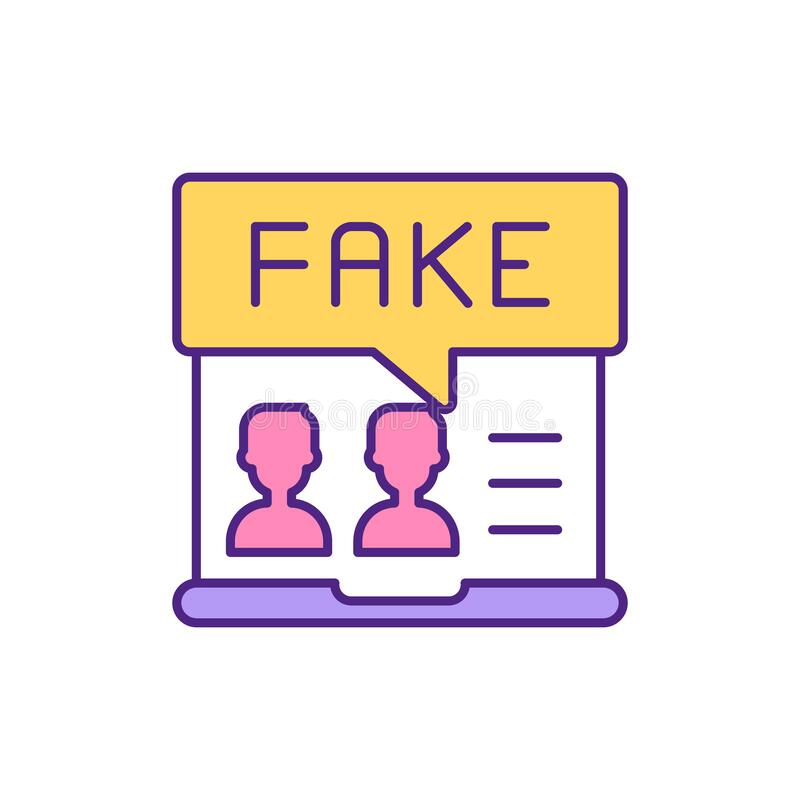
- Can be used by government related websites to detect whether the photos attached to a needed documentations are real or fake to prevent fraud.


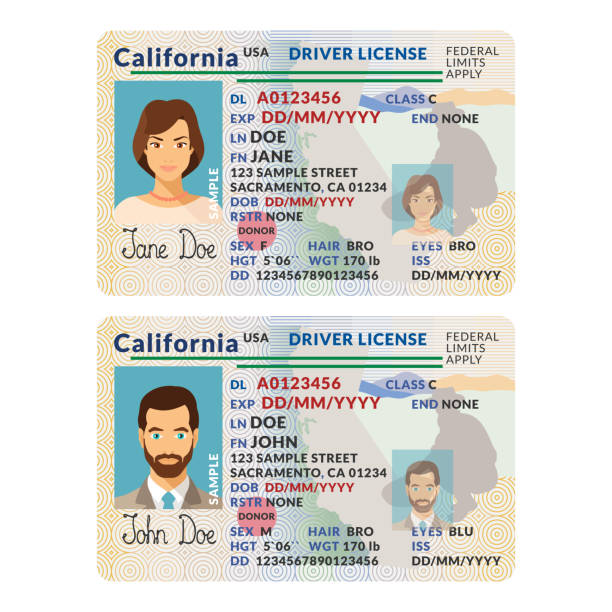
- Dating apps are highly in need to something like this to prevent multiple illegal actions like catfishing which might lead to alot of crimes as pedophilia , harassment and kidnapping.


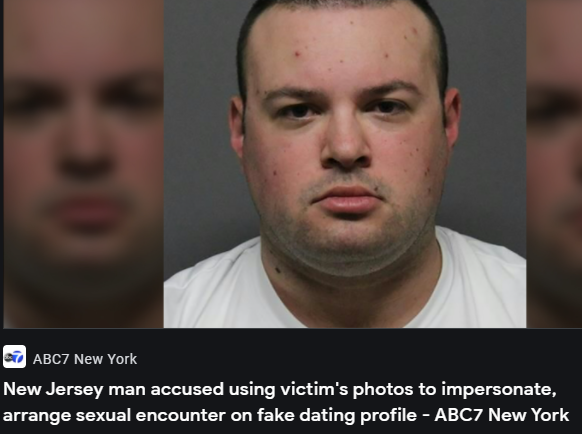 |

# import libraries

In [9]:
import os
import glob
import cv2
import numpy as np
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

# EDA

#### In the beginning, We will display the data and do some data visualization ..

In [29]:
path  = '/content/data/real_vs_fake/real-vs-fake/'

In [30]:
dataset = {"image_path":[],"img_status":[],"where":[]}
for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.jpg"):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append(where)
dataset = pd.DataFrame(dataset)
dataset

,image_path,img_status,where
0,/content/data/real_vs_fake/real-vs-fake/train/...,real,train
1,/content/data/real_vs_fake/real-vs-fake/train/...,real,train
2,/content/data/real_vs_fake/real-vs-fake/train/...,real,train
3,/content/data/real_vs_fake/real-vs-fake/train/...,real,train
4,/content/data/real_vs_fake/real-vs-fake/train/...,real,train
...,...,...,...
139995,/content/data/real_vs_fake/real-vs-fake/test/f...,fake,test
139996,/content/data/real_vs_fake/real-vs-fake/test/f...,fake,test
139997,/content/data/real_vs_fake/real-vs-fake/test/f...,fake,test
139998,/content/data/real_vs_fake/real-vs-fake/test/f...,fake,test


In [31]:
dataset.value_counts("img_status")

,count
img_status,
fake,70000
real,70000


<ipython-input-33-426edf47b5fd>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  real = dataset.value_counts("img_status")[1]
<ipython-input-33-426edf47b5fd>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fake = dataset.value_counts("img_status")[0]


Real: 70000,
Fake: 70000



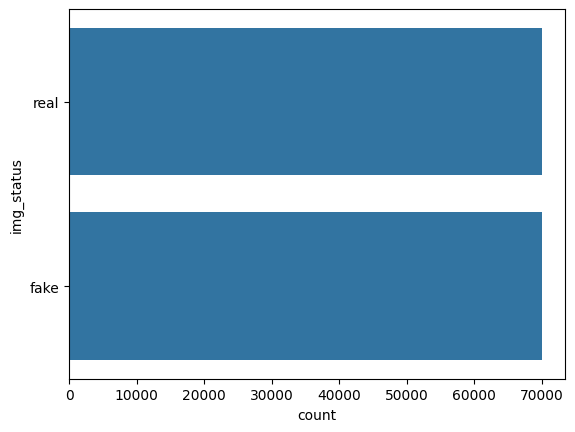

In [33]:


real = dataset.value_counts("img_status")[1]
fake = dataset.value_counts("img_status")[0]

print(f"Real: {real},\nFake: {fake}\n")
sns.countplot(dataset["img_status"])
plt.show()

#### As we can see the data is balanced, We have 70000 image for each category.

#### And here is some random samples from the data ..

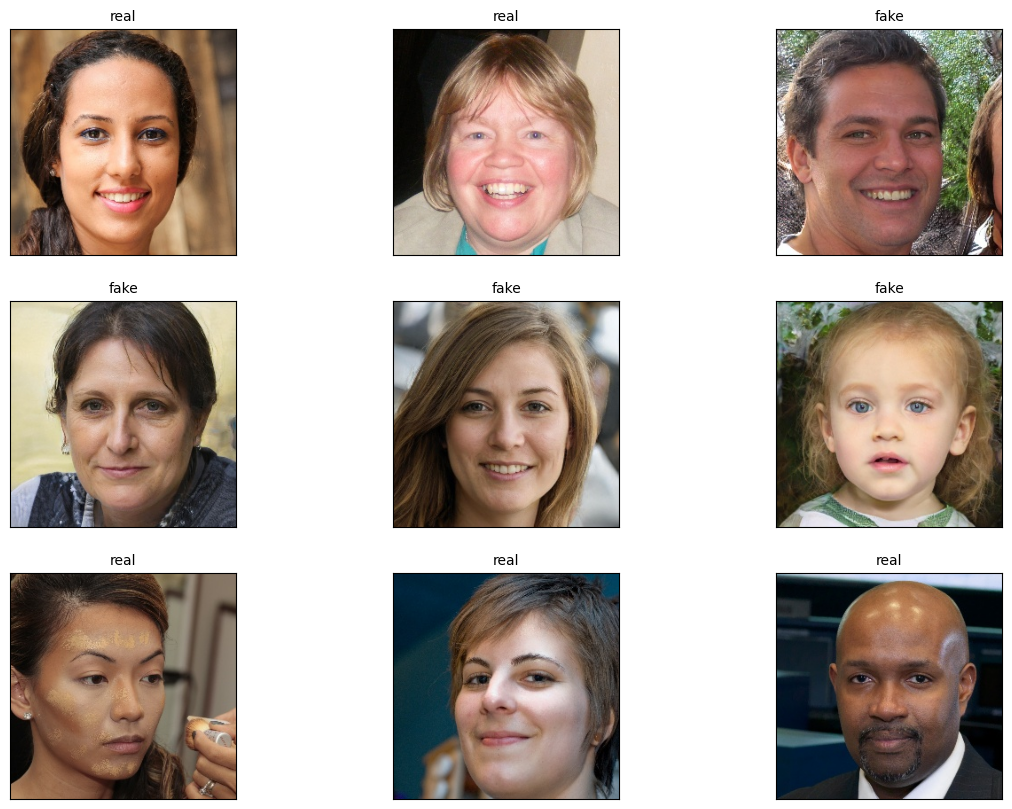

In [34]:
plt.figure(figsize = (14,10))
for i in range(9):
    random = np.random.randint(1,len(dataset))
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random, "img_status"], size = 10)
    plt.xticks([])
    plt.yticks([])

plt.show()

# Preprocessing

#### Know we will split the data by the generator to train,test and validation.

In [35]:
image_gen = ImageDataGenerator()

In [36]:
train_generator = image_gen.flow_from_directory(
    path + 'train/',
    target_size=(224, 224),
    batch_size=100,
    color_mode='grayscale',
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.


In [37]:
valid_generator = image_gen.flow_from_directory(
    path + 'valid/',
    target_size=(224, 224),
    batch_size=100,
    color_mode='grayscale',
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [38]:
test_generator = image_gen.flow_from_directory(
    path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    color_mode='grayscale',
    shuffle = False,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


# Modeling

### Classify The Model

In [39]:
densenet = DenseNet121( weights=None, include_top=False, input_shape=(224,224,1) )

In [40]:
model = Sequential([
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

In [41]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,031,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,032,257 (26.83 MB)

 Trainable params: 6,948,609 (26.51 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [44]:
history = model.fit(
    train_generator,
    steps_per_epoch = (100000//100),
    validation_data = valid_generator,
    validation_steps = (20000//100),
    epochs = 10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 334s 164ms/step - accuracy: 0.7081 - loss: 0.5601 - val_accuracy: 0.7759 - val_loss: 0.5217
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 120us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 157s 156ms/step - accuracy: 0.8856 - loss: 0.2684 - val_accuracy: 0.8253 - val_loss: 0.4243
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 157s 156ms/step - accuracy: 0.9459 - loss: 0.1393 - val_accuracy: 0.8356 - val_loss: 0.3845
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 157s 156ms/step - accuracy: 0.9683 - loss: 0.0826 - val_accuracy: 0.8748 - val_loss: 0.3629
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 32us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 157s 156ms/step - accuracy: 0.9790 - loss: 0.0554 - val_accuracy: 0.8880 - val_loss: 0.3309
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


In [45]:
model.save('Real VS Fake.h5')

In [ ]:
#load_model('./Real VS Fake.h5')

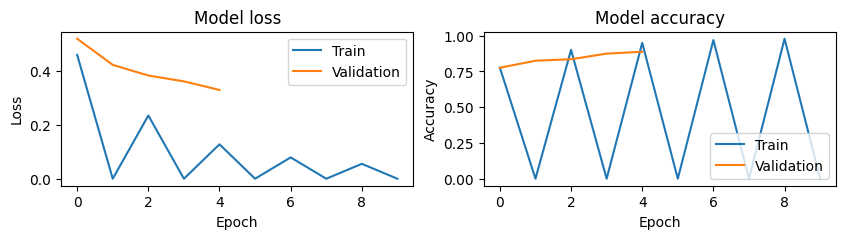

In [58]:
# Plot training & validation loss values
plt.figure(figsize=(10, 2))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

### Model evaluation

In [46]:
losses = pd.DataFrame(model.history.history)

ValueError: All arrays must be of the same length

In [51]:
losses[['loss','val_loss']].plot()

NameError: name 'losses' is not defined

In [ ]:
losses[['accuracy','val_accuracy']].plot()

### prediction

In [47]:
y_pred = model.predict(test_generator)
y_test = test_generator.classes

20000/20000 ━━━━━━━━━━━━━━━━━━━━ 190s 9ms/step


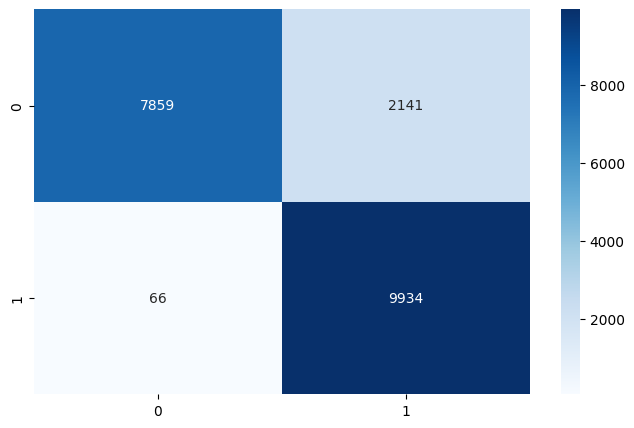

In [48]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [49]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.98528087
AP Score: 0.983548482016632


In [50]:
print(metrics.classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88     10000
           1       0.82      0.99      0.90     10000

    accuracy                           0.89     20000
   macro avg       0.91      0.89      0.89     20000
weighted avg       0.91      0.89      0.89     20000



#### Let me Know your opinion about my project ^_^